<a href="https://colab.research.google.com/github/sheha919/Stroke_Prediction/blob/main/stroke_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Information about the dataset

source: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

**Attribute Information**

1. id: unique identifier
2. gender: "Male", "Female" or "Other"
3. age: age of the patient
4. hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5. heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6. ever_married: "No" or "Yes"
7. work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8. Residence_type: "Rural" or "Urban"
9. avg_glucose_level: average glucose level in blood
10. bmi: body mass index
11. smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12. stroke: 1 if the patient had a stroke or 0 if not *Note: "Unknown" in smoking_status means that the information is unavailable for this patient

#Import Libraries


In [71]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay\
,precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn import set_config
set_config(display='diagram')

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as smote_pipe
from sklearn.decomposition import PCA

#Load Data

In [3]:
df = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
#make a copy
ml_df = df.copy()
ml_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


#Explore Data

In [5]:
ml_df.shape

(5110, 12)

In [6]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [7]:
#checking for duplicates
ml_df.duplicated().sum()

0

No duplicate data

In [8]:
#checking for missing data
ml_df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

'bmi' Column has 201 missing data. I will require to impute using Simple Imputer at the data preprocessing step.

In [9]:
#checking the balance level of data
ml_df['stroke'].value_counts(normalize = True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

The data set is unbalanced, need to fix this. 

In [10]:
#checking for inconsistencies in categorical data
data_types = ml_df.dtypes
str_object = data_types[data_types=='object'].index

for i in str_object:
  print(f'Column Name: {i}')
  print(ml_df[i].value_counts())
  print('\n')

Column Name: gender
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64


Column Name: ever_married
Yes    3353
No     1757
Name: ever_married, dtype: int64


Column Name: work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64


Column Name: Residence_type
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64


Column Name: smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64




- Seems like there are no inconsistencies in the categorical data
- In the description of database, it is mentioned that "Unknown" in smoking_status means that the information is unavailable for this patient. Therefore, the 'unknown' values can be considered as missing data.
- All categorical data columns ontain nominal data

In [11]:
#replacing 'unknown' with NAN
ml_df['smoking_status'].replace('Unknown', np.nan, inplace = True)
ml_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [12]:
#rechecking missing data
ml_df.isna().sum()

id                      0
gender                  0
age                     0
hypertension            0
heart_disease           0
ever_married            0
work_type               0
Residence_type          0
avg_glucose_level       0
bmi                   201
smoking_status       1544
stroke                  0
dtype: int64

Now, both 'bmi' and 'smoking_status' have missing data


In [13]:
#checking the inconsistencies in numerical data
ml_df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


- 'id' column does not provide useful data to the analysis. Therefore, it can be removed.

In [14]:
ml_df.drop(columns = ['id'], axis = 1, inplace = True)
ml_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


- Since it is suspicious to have a decimal number as the age, just explore the 'age' column 

In [15]:
#explore the age column
ml_df[ml_df['age']<1]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
363,Female,0.64,0,0,No,children,Urban,83.82,24.9,NaN,0
376,Female,0.88,0,0,No,children,Rural,88.11,15.5,NaN,0
564,Female,0.32,0,0,No,children,Rural,73.71,16.2,NaN,0
982,Male,0.88,0,0,No,children,Rural,157.57,19.2,NaN,0
996,Male,0.24,0,0,No,children,Rural,118.87,16.3,NaN,0
1093,Female,0.32,0,0,No,children,Rural,55.86,16.0,NaN,0
1206,Female,0.72,0,0,No,children,Urban,66.36,23.0,NaN,0
1317,Male,0.80,0,0,No,children,Rural,98.67,17.5,NaN,0
1600,Male,0.40,0,0,No,children,Urban,109.56,14.3,NaN,0
1614,Female,0.08,0,0,No,children,Urban,139.67,14.1,NaN,0


- Seems like all the entries which have less than 1 year as the age are children. Therefore, no need to change anything in 'age column'.

- All other numerical columns look fine too.

# Data Analysis and Visualization

## Univarient Analysis

In [16]:
ml_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [17]:
data_types = ml_df.dtypes
str_num = data_types[data_types!='object'].index
str_num

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke'],
      dtype='object')

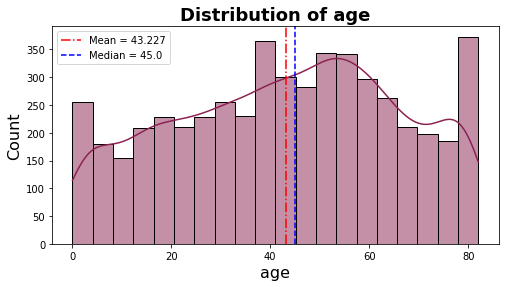

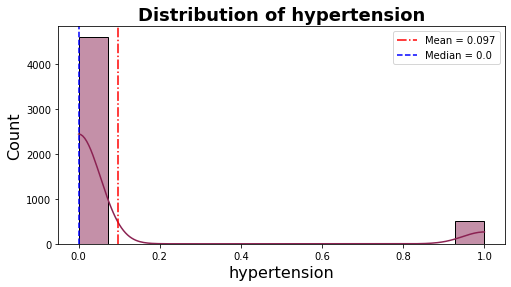

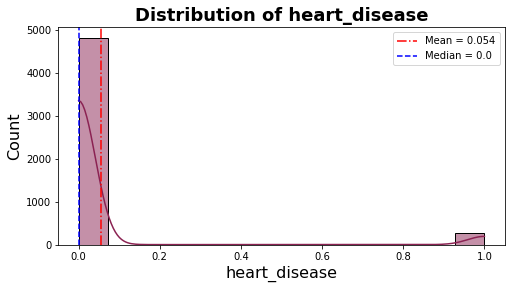

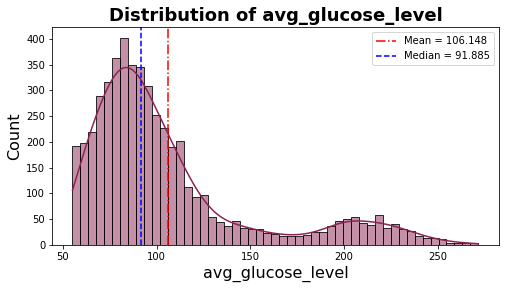

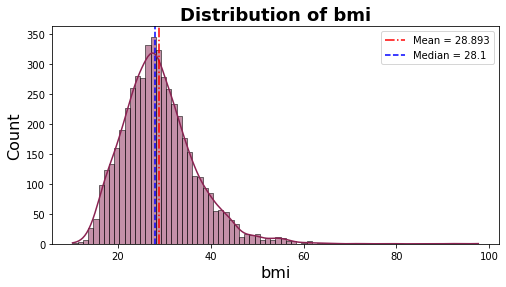

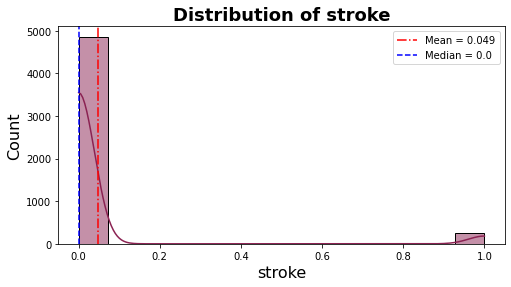

In [18]:
from pyparsing.helpers import line
for i in str_num:
  fig, ax = plt.subplots(figsize= (8,4))
  sns.histplot(data = ml_df, x = i, bins = 'auto', kde=True, color = '#8B2252')
  avg = ml_df[i].mean()
  ax.axvline(avg, ls = '-.', color = 'red', label = f'Mean = {round(avg,3)}')
  median = ml_df[i].median()
  ax.axvline(median, ls = '--', color = 'blue', label = f'Median = {round(median,3)}')
  ax.set_xlabel(i, fontsize = 16)
  ax.set_ylabel('Count', fontsize =16)
  ax.set_title(f'Distribution of {i}', fontsize = 18, fontweight = 'bold')
  ax.legend();



- Above histrogams illustrate the distribution of each feature with its mean and median values.
- According to them, not any of features showing outliers.

##Multivariate Analysis 

In [19]:
ml_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Text(0.5, 1.0, 'Correlation between features')

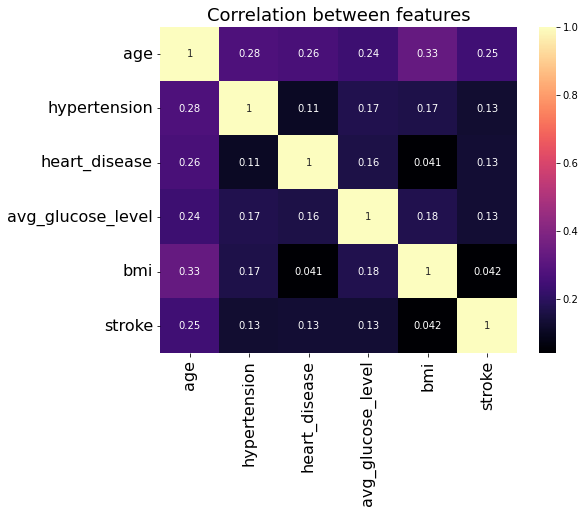

In [20]:
corr = ml_df.corr()
plt.figure(figsize = (8,6))
sns.heatmap(data =corr, annot = True, cmap = 'magma')
plt.xticks(fontsize =16)
plt.yticks(fontsize =16)
plt.title('Correlation between features', fontsize =18)

- The highest correlation shows between age and BMI which is 0.33
- The lowest correlation shows between BMI and having a heart disease or not

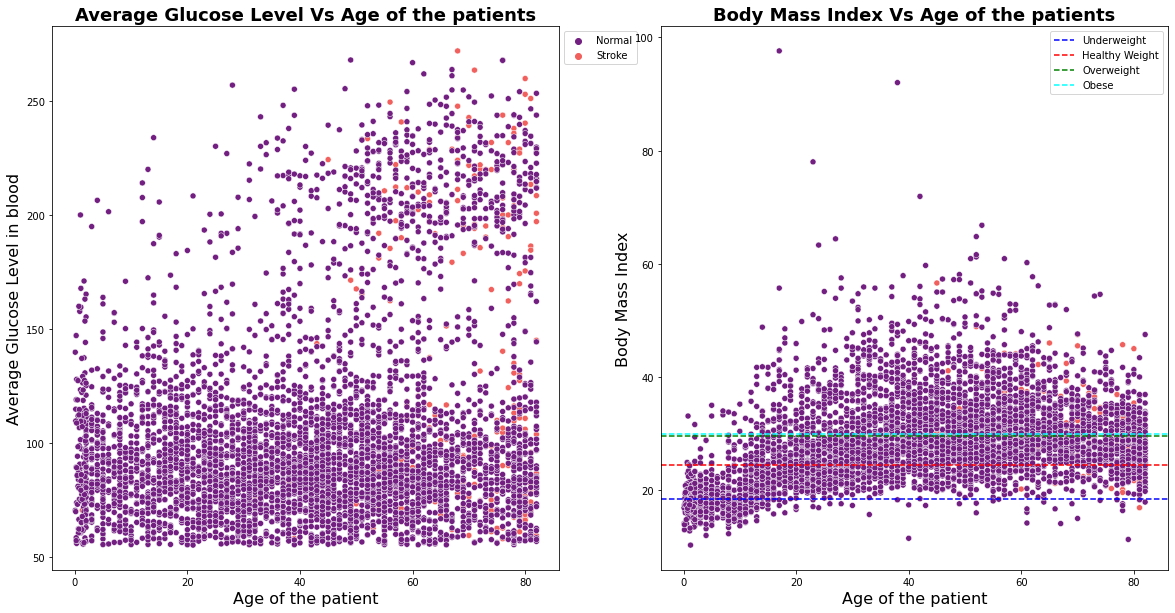

In [97]:
fig, axes = plt.subplots(1,2, figsize = (20,10))
sns.scatterplot(data = ml_df, x = 'age', y = 'avg_glucose_level', hue = 'stroke', palette="magma", ax= axes[0])
legend_labels, _= axes[0].get_legend_handles_labels()
axes[0].legend(legend_labels, ['Normal', 'Stroke'], bbox_to_anchor=(1,1))
axes[0].set_xlabel('Age of the patient', fontsize = 16)
axes[0].set_ylabel('Average Glucose Level in blood', fontsize = 16)
axes[0].set_title('Average Glucose Level Vs Age of the patients', fontsize = 18, fontweight = 'bold')


sns.scatterplot(data = ml_df, x = 'age', y = 'bmi', hue = 'stroke', palette="magma", ax = axes[1], legend= False)
axes[1].set_xlabel('Age of the patient', fontsize = 16)
axes[1].set_ylabel('Body Mass Index', fontsize = 16)
axes[1].set_title('Body Mass Index Vs Age of the patients', fontsize = 18, fontweight = 'bold')
axes[1].axhline(18.5, ls = '--', color = 'blue', label = 'Underweight')
axes[1].axhline(24.5, ls = '--', color = 'red', label = 'Healthy Weight')
axes[1].axhline(29.5, ls = '--', color = 'green', label = 'Overweight')
axes[1].axhline(30, ls = '--', color = 'cyan', label = 'Obese')

axes[1].legend()

- Most of the patients have average glucose level below ~ 140. But the patients with higher than 140 are increasing with as the age increment. 
- Everyone with stroke fall above the age of 40 years.
- Most of patients are below the ~ 50 level of BMI.
- According to the CDC, patients can be catergorized as;
  - BMI is less than 18.5: Underweight range
  - BMI is 18.5 to 24.9: Healthy Weight range
  - BMI is 25.0 to 29.9: Overweight range
  - BMI is 30.0 or higher: Obese range


(source: https://www.cdc.gov/healthyweight/assessing/index.html)


- Most of the underweight patients fall under 20 years
- The majority of patients suffer from obesity are in between 20 and 60 years of age. 

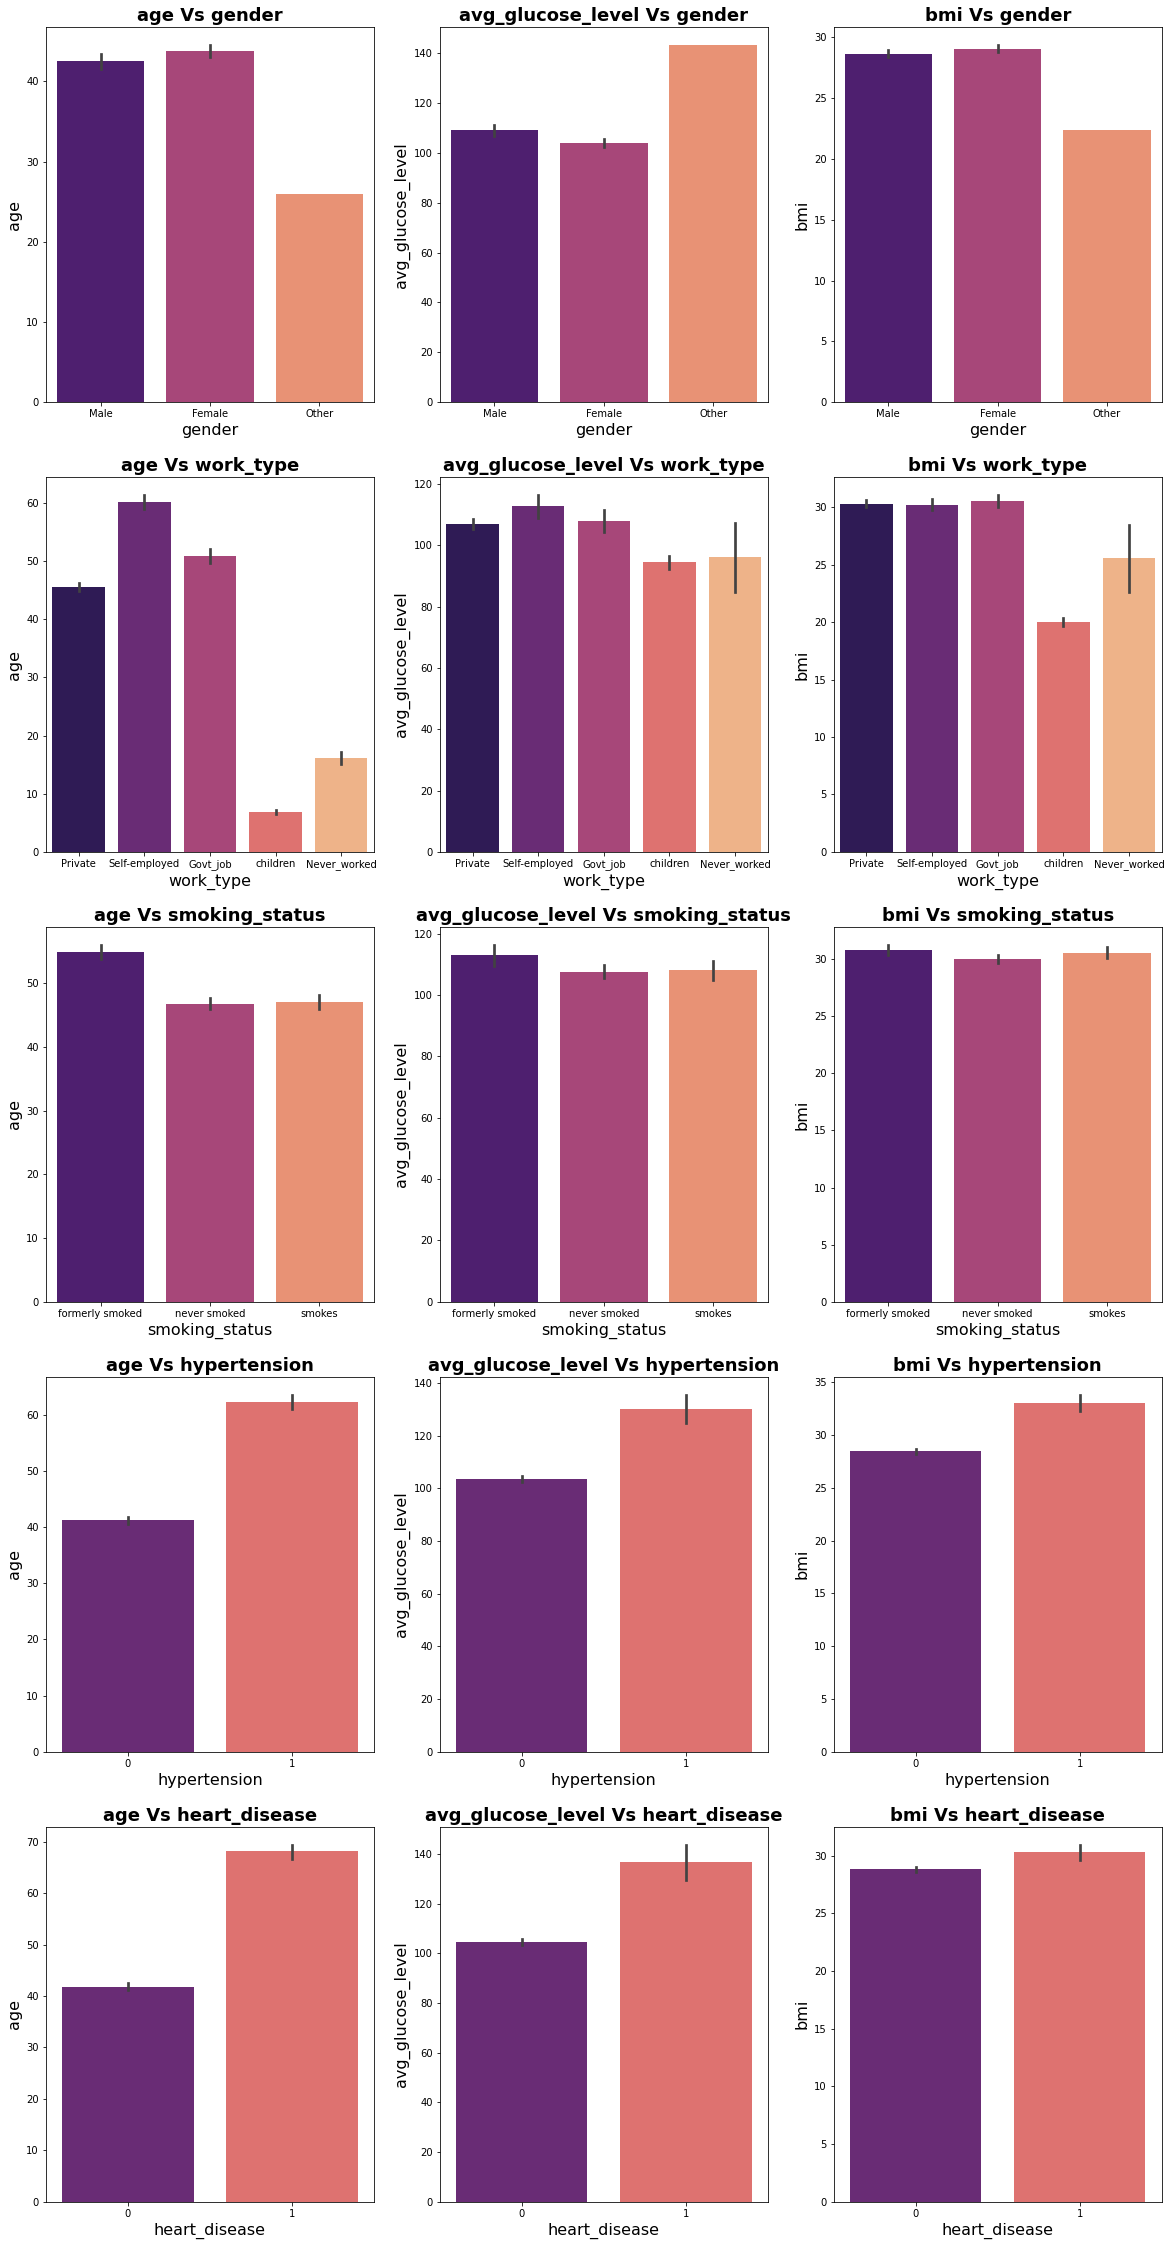

In [22]:
cat_col = ['gender', 'work_type', 'smoking_status', 'hypertension',	'heart_disease']
num_col = ['age', 'avg_glucose_level', 'bmi']

fig, axes = plt.subplots(len(cat_col), len(num_col), figsize = (20,40))
for i, icol in enumerate(cat_col):
  for j, jcol in enumerate(num_col):
    sns.barplot(data = ml_df, x = icol, y = jcol, palette="magma", ax = axes[i,j])
    axes[i,j].set_xlabel(icol, fontsize = 16)
    axes[i,j].set_ylabel(jcol, fontsize = 16)
    axes[i,j].set_title(f'{jcol} Vs {icol}', fontsize = 18, fontweight = 'bold');


According to the above grid of bar charts;
  - Male and female patients have almost similar mean age, glucose levels and BMI
  - For adult patients, the BMI and glucose levels do not depend on the job type. (Never worked patients can be consider as teenagers, thus not catergorized as adults)
  - Seems like average glucose and BMI do not vary on the smoking status much.
  - Patients with hypertension and heart disease are also suffering from obesity and prediabetes or diabates.
  

According to CDC;
  - Diabetes:	above	126 mg/dL 
  - Prediabetes:	100 – 125 mg/dL	
  - Normal: Below 99 mg/dL 
  
(source: https://www.cdc.gov/diabetes/basics/getting-tested.html#:~:text=Fasting%20Blood%20Sugar%20Test&text=A%20fasting%20blood%20sugar%20level,higher%20indicates%20you%20have%20diabetes.)

#Evaluvate Function

In [23]:
## define the evaluate_classification function here

def evaluate_classiffication(pipe, X_test, y_test, label="Test Data"):
  test_preds = pipe.predict(X_test)

  print('---'*20)
  print(f"[i] CLASSIFICATION REPORT FOR: {label}")
  print('---'*20)

  # print the classiffication report from the test data
  print(classification_report(y_test, test_preds))

  fig, axes = plt.subplots(1,2, figsize=(15,5))

  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_test, test_preds, 
               normalize='true', cmap='Greens',
               ax = axes[0]);

  RocCurveDisplay.from_estimator(pipe, X_test, y_test, ax=axes[1])
  plt.show()

#Data Preprocessing

In [24]:
ml_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [25]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     3566 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [26]:
#missing data
ml_df.isna().sum()

gender                  0
age                     0
hypertension            0
heart_disease           0
ever_married            0
work_type               0
Residence_type          0
avg_glucose_level       0
bmi                   201
smoking_status       1544
stroke                  0
dtype: int64

##Validate Split

In [27]:
y = ml_df['stroke']
X = ml_df.drop(columns = ['stroke'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y)

##Instantiate Column Transformers

In [28]:
scaler = StandardScaler()
ohe = OneHotEncoder(sparse = False, handle_unknown= 'ignore')
median_imputer = SimpleImputer(strategy = 'median')
freq_imputer = SimpleImputer(strategy = 'most_frequent')

## Instanttiate Column selectors

In [29]:
num_selector = make_column_selector(dtype_include = 'number')
cat_selector = make_column_selector(dtype_include='object')

##Instantiate preprocessor

In [30]:
num_pipe = make_pipeline(median_imputer, scaler)
cat_pipe = make_pipeline(freq_imputer, ohe)

num_tuple = (num_pipe, num_selector)
cat_tuple = (cat_pipe, cat_selector)

preprocessor = make_column_transformer(num_tuple, cat_tuple, remainder='drop')
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f7c730fddd0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f7c730fd750>)])

#Application of PCA

In [31]:
print(f'Shape of X_train before PCA: {X_train.shape}')

Shape of X_train before PCA: (3832, 10)


In [32]:
processed_x = preprocessor.fit_transform(X_train)
print(f'Shape of processed X_train before PCA: {processed_x.shape}')
pca = PCA()
print(f'Shape of processed X_train after PCA: {pca.fit_transform(processed_x).shape}')

Shape of processed X_train before PCA: (3832, 20)
Shape of processed X_train after PCA: (3832, 20)


Text(0, 0.5, 'Proportion of Explained Variance')

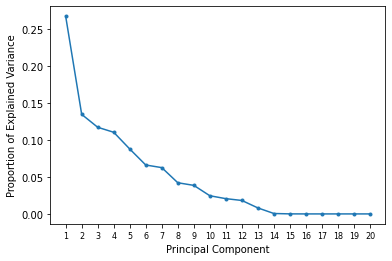

In [33]:
plt.plot(range(1,21), pca.explained_variance_ratio_, marker = '.')
plt.xticks(ticks = range(1, 21), fontsize=8)
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Explained Variance')

- The variance is approximately zero from 14th principle component to 20th. 
- Therefore, n_component = 13 is seleced for further optimizations.

In [34]:
#instantiate PCA 
pca = PCA(n_components =13)

#Logistic Regression Model

## Initial model

In [35]:
logreg= LogisticRegression(random_state =42)
logreg_pipe = make_pipeline(preprocessor, logreg)
logreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f7c730fddd0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f7c730fd750>)])),
                ('logisticregression', LogisticRegression(random_state=42))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1216
           1       1.00      0.02      0.03        62

    accuracy                           0.95      1278
   macro avg       0.98      0.51      0.50      1278
weighted avg       0.95      0.95      0.93      1278



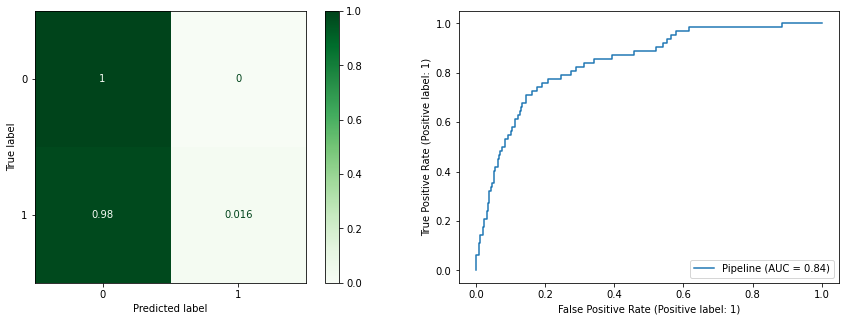

In [36]:
evaluate_classiffication(logreg_pipe, X_test, y_test, label="Test Data")

- In this problem, we have to minimize the number of false negatives to reduce the risk on the patient.
- Therefore, the recall score is a very important metric to measure.
- But in initial logistic regression model produced a very low value(0.016) for positive cases. 

## Addressing Class Imbalance with SMOTE and apply PCA

In [37]:
#define the function for smote model
def smote_pca_model(model):
  smote = SMOTE(sampling_strategy='auto', random_state=42)
  model_smote_pca_pipe = smote_pipe(preprocessor, smote, pca, model)
  model_smote_pca_pipe.fit(X_train, y_train)

  return (model_smote_pca_pipe)

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.74      0.84      1216
           1       0.13      0.76      0.22        62

    accuracy                           0.74      1278
   macro avg       0.56      0.75      0.53      1278
weighted avg       0.94      0.74      0.81      1278



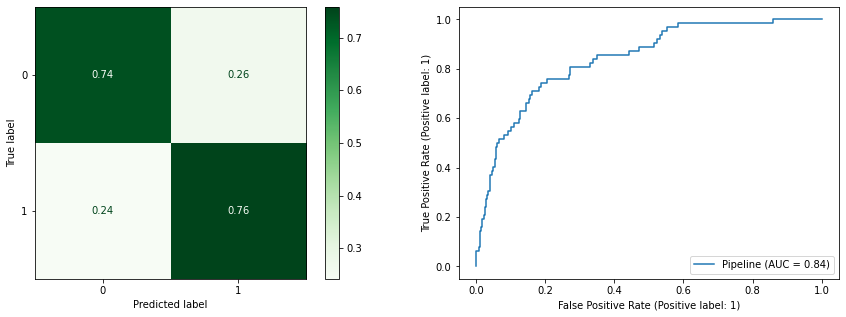

In [38]:
logreg_smote_pipe = smote_pca_model(logreg)
evaluate_classiffication(logreg_smote_pipe, X_test, y_test, label="Test Data")

- When I tried the oversmapling with smote due to the imbalanceness of the data set and applied PCA, the false negative(FN) percentage decreased 99% to 24%.
- The recall score also increased to 0.76 for postive cases.

#KNN Model

##Initial Model

In [39]:
knn = KNeighborsClassifier()
knn_pipe = make_pipeline(preprocessor, knn)
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f7c730fddd0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f7c730fd750>)])),
                ('kneighborsclassifier', KNeighborsClassifier())])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1216
           1       0.00      0.00      0.00        62

    accuracy                           0.94      1278
   macro avg       0.48      0.50      0.49      1278
weighted avg       0.90      0.94      0.92      1278



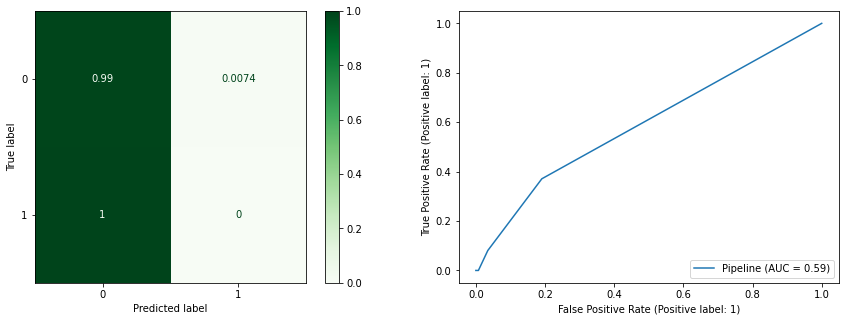

In [40]:
evaluate_classiffication(knn_pipe, X_test, y_test, label="Test Data")

- The initial KNN model is not producting true postives at all while show all postive cases as negatives.
- The quality of the model is even lower for KNN model comparative to Logestic regression model.

## Addressing Class Imbalance with SMOTE and apply PCA

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.82      0.88      1216
           1       0.08      0.29      0.12        62

    accuracy                           0.79      1278
   macro avg       0.52      0.55      0.50      1278
weighted avg       0.91      0.79      0.85      1278



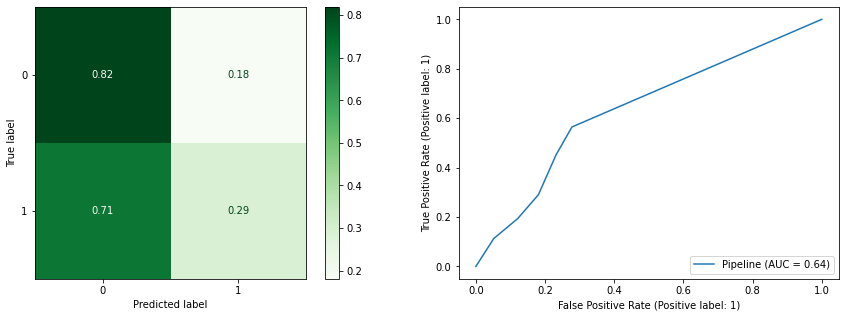

In [41]:
knn_smote_pipe = smote_pca_model(knn)
evaluate_classiffication(knn_smote_pipe, X_test, y_test, label="Test Data")

- Here the oversampling and PCA did not work well as the smote model of logistic regreassion.
- The FN persentage decresed from 100% to 71% which is good yet not better than smote model of logistic regression.

#Random Forest Model

##Initial Model

In [42]:
rf = RandomForestClassifier(random_state =42)
rf_pipe = make_pipeline(preprocessor, rf)
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f7c730fddd0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f7c730fd750>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1216
           1       0.20      0.02      0.03        62

    accuracy                           0.95      1278
   macro avg       0.58      0.51      0.50      1278
weighted avg       0.92      0.95      0.93      1278



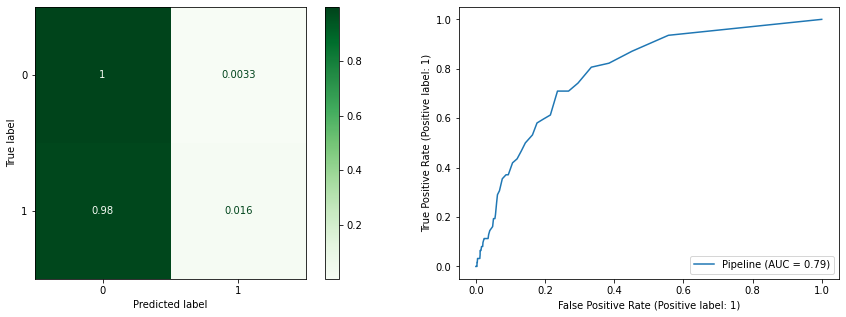

In [43]:
evaluate_classiffication(rf_pipe, X_test, y_test, label="Test Data")

- The recall scores and percentage of FN are similar to the values obtained for initial model of logestic regression.
- According to the ROC, the quality of the initial model of random forest is lower than the initial model of logestic regression.

## Addressing Class Imbalance with SMOTE and apply PCA

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1216
           1       0.10      0.16      0.12        62

    accuracy                           0.89      1278
   macro avg       0.53      0.54      0.53      1278
weighted avg       0.91      0.89      0.90      1278



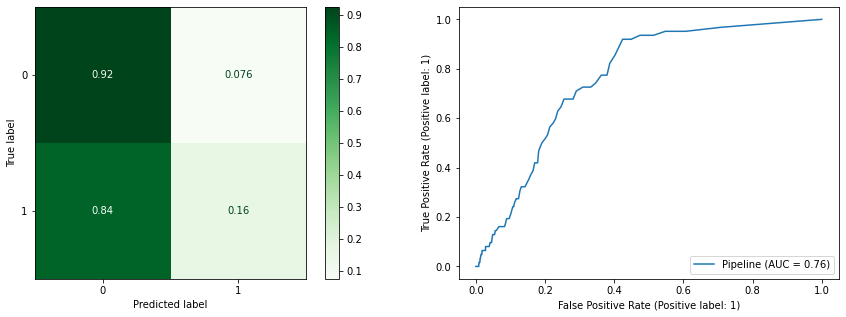

In [44]:
rf_smote_pipe = smote_pca_model(rf)
evaluate_classiffication(rf_smote_pipe, X_test, y_test, label="Test Data")

- For the smote model of random forest, the FN percentage has decreased from 98% to 84% which is a small improvement.

- Out of all initial models of classification models I used, logistic regresion was the good one.
- It can be further improved by SMOTE oversampling.

#Optimizing the models

##For Logistic Regression model

In [45]:
logreg_smote_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f7c730fddd0>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                

In [46]:
logref_smote_param_grid = {'smote__k_neighbors':range(2,7),
                 'logisticregression__C': [0.1, 1, 10, 100],
                 'logisticregression__penalty':['l1','l2'],
                 'logisticregression__max_iter': [100, 1000]}

In [47]:
logref_smote_gs = GridSearchCV(logreg_smote_pipe, logref_smote_param_grid, cv =5)
logref_smote_gs.fit(X_train, y_train);

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
200 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)


In [48]:
print(f'Best parameters: {logref_smote_gs.best_params_}')

Best parameters: {'logisticregression__C': 10, 'logisticregression__max_iter': 100, 'logisticregression__penalty': 'l2', 'smote__k_neighbors': 3}


In [49]:
logref_opt = logref_smote_gs.best_estimator_
logref_opt.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f7c72bbabd0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f7c72c243d0>)])),
                ('smote', SMOTE(k_neighbors=3, random_state=42)),
                ('pca', PCA(n_components=13)),
                ('logisticregression',
                 LogisticRegression(C=10, random_state=42))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      1216
           1       0.13      0.81      0.22        62

    accuracy                           0.73      1278
   macro avg       0.56      0.77      0.53      1278
weighted avg       0.95      0.73      0.81      1278



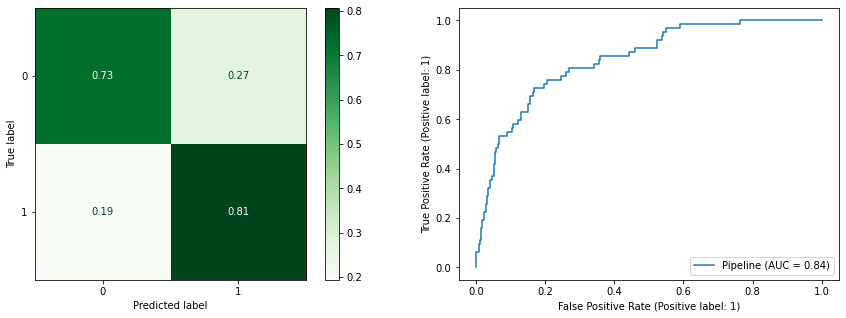

In [50]:
evaluate_classiffication(logref_opt, X_test, y_test, label="Test Data")

The optimized logistic regression model decreased the percentage of FN from 24% to 19% and increased recall score to 81% for positive cases.

##For KNN model

In [51]:
knn_smote_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f7c730fddd0>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                

In [52]:
knn_smote_param_grid = {'smote__k_neighbors':range(1,7)}

In [53]:
knn_smote_gs = GridSearchCV(knn_smote_pipe, knn_smote_param_grid, cv =5)
knn_smote_gs.fit(X_train, y_train);

In [54]:
print(f'Best parameters: {knn_smote_gs.best_params_}')

Best parameters: {'smote__k_neighbors': 1}


In [55]:
knn_opt = knn_smote_gs.best_estimator_
knn_opt.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f7c72a6f6d0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f7c7292d590>)])),
                ('smote', SMOTE(k_neighbors=1, random_state=42)),
                ('pca', PCA(n_components=13)),
                ('kneighborsclassifier', KNeighborsClassifier())])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.85      0.90      1216
           1       0.07      0.24      0.11        62

    accuracy                           0.82      1278
   macro avg       0.52      0.54      0.51      1278
weighted avg       0.91      0.82      0.86      1278



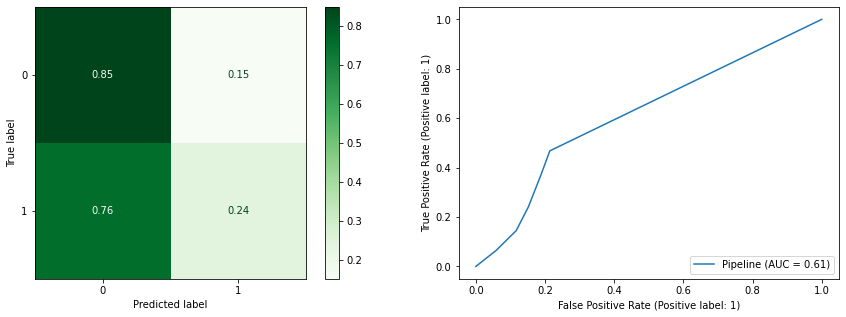

In [56]:
evaluate_classiffication(knn_opt, X_test, y_test, label="Test Data")

-The TN percentage has increased up to 85% while TP has decresed to 24%.
- And also the percentage of FN has increaced to 76% from 71% which is not good.
- The quality of optimized KNN model also decreased by 2% comparative to its initial model with SMOTE oversampling.

##Random Forest Model

In [57]:
rf_smote_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f7c730fddd0>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                

In [58]:
rf_smote_param_grid = {'smote__k_neighbors':range(1,7),
                 'randomforestclassifier__n_estimators': [20,30,50,100,150,200]}

In [59]:
rf_smote_gs = GridSearchCV(rf_smote_pipe, rf_smote_param_grid, cv =5)
rf_smote_gs.fit(X_train, y_train);

In [60]:
print(f'Best parameters: {rf_smote_gs.best_params_}')

Best parameters: {'randomforestclassifier__n_estimators': 30, 'smote__k_neighbors': 1}


In [61]:
rf_opt = rf_smote_gs.best_estimator_
rf_opt.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f7c728e7d50>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f7c728e7e10>)])),
                ('smote', SMOTE(k_neighbors=1, random_state=42)),
                ('pca', PCA(n_components=13)),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=30, random_state=42))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1216
           1       0.13      0.15      0.14        62

    accuracy                           0.91      1278
   macro avg       0.54      0.55      0.54      1278
weighted avg       0.92      0.91      0.91      1278



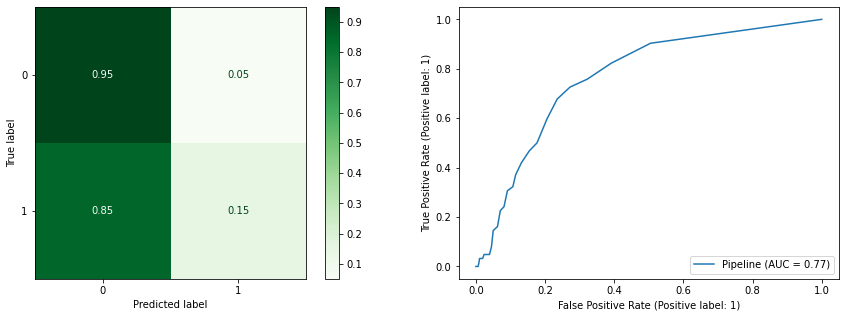

In [62]:
evaluate_classiffication(rf_opt, X_test, y_test, label="Test Data")

- the quatity of optimized random forest model has increased from 2% 
- But FN percentage has increased by 5% comparative to initial random forest model with oversampling which is not good.

Out of the 3 models, the optimized logistic regression model can be selected as best model according to the recall score.

#Evaluvation

In [84]:
def eval_summary_classification(pipe, y_test = y_test, X_test = X_test):
  
  test_pred = pipe.predict(X_test)

  precision= round(precision_score(y_test, test_pred),3)
  recall = round(recall_score(y_test, test_pred),3)
  f1 = round(f1_score(y_test, test_pred),3)
  accuracy = round(accuracy_score(y_test, test_pred),3)

  return (precision, recall, f1, accuracy )

In [106]:
scores = pd.DataFrame(columns = ['Model', 'Precision', 'Recall', 'F1 Score', 'Accuracy' ])

model = ['Logistic Regression', 'KNN', 'Random Forest']
pipe = [logref_opt, knn_opt, rf_opt]

for i in range(len(model)):
  scores.loc[i, 'Model'] = model[i]
  scores.loc[i,'Precision'], scores.loc[i,'Recall'], scores.loc[i,'F1 Score'], scores.loc[i,'Accuracy'] = eval_summary_classification(pipe[i])

  

In [107]:
scores.set_index('Model', inplace = True) 

In [117]:
scores

,Precision,Recall,F1 Score,Accuracy
Model,,,,
Logistic Regression,0.131,0.806,0.225,0.73
KNN,0.075,0.242,0.115,0.818
Random Forest,0.129,0.145,0.136,0.911


Even though, the highest accuracy is co,img from the optimized random forest model, here we are trying to maximize recall score to minimize the rist on patietns.